In [235]:
import scipy as sp
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns
import jenkspy as jp
import math
from sklearn.manifold import MDS
from itertools import pairwise, combinations,product

In [236]:
def precision(answer, targets):
    retrieved_relevant = set(answer).intersection(set(targets))
    return len(retrieved_relevant) / len(answer) if len(answer) > 0 else 0


def recall(answer, targets):
    relevant = set(targets)
    retrieved_relevant = set(answer).intersection(relevant)
    return len(retrieved_relevant) / len(relevant) if len(relevant) > 0 else 0


def f1score(answer, targets):
    p = precision(answer, targets)
    r = recall(answer, targets)
    overlap = set(answer).intersection(set(targets))
    return 2 * (r * p) / (r + p) if len(overlap) > 0 else 0

def parse_timed_answer(timed_response):
    answer, time = timed_response.split(';')
    response = [int(i) for i in answer.split(',')]  if len(answer) > 0 else []
    time = int(time)
    return response, time

f1score([1, 2, 3], [4, 5, 6])
parse_timed_answer(';424')

([], 424)

In [237]:
df = pd.read_csv('./survey.csv')
pd.set_option('display.max_rows', 10)
df[df.columns[:15]]

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,consent,abort,preliminaries,screen,screeningsinfo,age,vision,dyslexia
0,29,2024-04-10 10:51:39,57.0,en,1388306228,2024-04-10 10:46:10,2024-04-10 10:51:39,Yes,NaN,NaN,1680;940;2,NaN,999.0,Yes,No
1,30,NaN,-1.0,en,695366367,2024-04-10 10:52:59,2024-04-10 10:53:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31,2024-04-10 12:25:14,57.0,en,2137621532,2024-04-10 11:51:44,2024-04-10 12:25:13,Yes,NaN,NaN,378;660;2.857142857142857,NaN,27.0,Yes,No
3,32,NaN,2.0,en,156759560,2024-04-10 12:18:31,2024-04-10 12:18:34,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33,2024-04-10 12:38:44,57.0,en,46242874,2024-04-10 12:19:48,2024-04-10 12:38:44,Yes,NaN,NaN,2560;1440;1.5,NaN,26.0,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,118,2024-04-18 20:15:50,57.0,en,829929296,2024-04-18 19:48:45,2024-04-18 20:15:50,Yes,NaN,NaN,1512;892;2,NaN,21.0,Yes,No
90,119,2024-04-18 20:49:49,57.0,en,1074584099,2024-04-18 20:21:11,2024-04-18 20:49:49,Yes,NaN,NaN,2560;1313;1,NaN,30.0,Yes,No
91,120,2024-04-18 21:32:45,57.0,en,790565080,2024-04-18 21:12:05,2024-04-18 21:32:45,Yes,NaN,NaN,1071;948;2,NaN,23.0,Yes,No
92,121,NaN,18.0,en,1896831768,2024-04-18 21:34:16,2024-04-18 21:48:37,Yes,NaN,NaN,1920;1000;1,NaN,26.0,Yes,No


In [238]:
from functools import partial

# exclude data
print(f'# All responses: {len(df)}')

# only complete responses (they have a submit date)
df = df[pd.notna(df["submitdate"])]
print(f'# Complete responses: {len(df)}')
# only consent - no technical reasons why they would still be here but you never know
df = df[df["consent"] == "Yes"]
print(f'# Consentful responses: {len(df)}')
# no dyslexia
df = df[df["dyslexia"] == "No"]
# no vision or color impairment
df = df[(df["vision"] == "Yes") & (df["color"] == "No")]
print(f'# Screened responses: {len(df)}')
# age: 18–120
# NP is response with age = 999
df = df[(df["age"] >= 18) & (df["age"] <= 120)]
print(f'# Screened responses incl. age: {len(df)}')

# wrong answers to control questions
# control questions have glyph 40 as reference
# the target cluster is glyphs 36,37,38,39,40,41
# so correct answers are a permutation of 36,37,38,39,41
targets = [36, 37, 38, 39, 41]


def is_control_correct(q, row):
    response,_ = parse_timed_answer(row[q])
    return f1score(response, targets) > 0.9999


df["control1_correct"] = df.apply(partial(is_control_correct, "control1"), axis=1)
df["control2_correct"] = df.apply(partial(is_control_correct, "control2"), axis=1)
df["control4_correct"] = df.apply(partial(is_control_correct, "control4"), axis=1)

# exclude who got any one control question wrong
df = df[df["control1_correct"] & df["control2_correct"] & df["control4_correct"]]
print(f'# Responses incl. controls: {len(df)}')
df

# All responses: 94
# Complete responses: 54
# Consentful responses: 54
# Screened responses: 52
# Screened responses incl. age: 51
# Responses incl. controls: 49


,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,consent,abort,preliminaries,...,confidence[T4_W0],confidence[T4_W5],confidence[T4_W1],opentext,gender,education,input,control1_correct,control2_correct,control4_correct
2,31,2024-04-10 12:25:14,57.0,en,2137621532,2024-04-10 11:51:44,2024-04-10 12:25:13,Yes,NaN,NaN,...,3.0,4.0,2.0,Finding glyphs sharing the same category was g...,Male,Undergraduate degree (BSc / BA / other),Touch,True,True,True
4,33,2024-04-10 12:38:44,57.0,en,46242874,2024-04-10 12:19:48,2024-04-10 12:38:44,Yes,NaN,NaN,...,5.0,3.0,4.0,NaN,Male,High school (A-levels / Matura),Mouse,True,True,True
7,36,2024-04-10 15:26:57,57.0,en,1262101183,2024-04-10 14:15:18,2024-04-10 15:26:57,Yes,NaN,NaN,...,4.0,3.0,2.0,1) bright red would be pink to me \n2) in the ...,Female,High school (A-levels / Matura),Mouse,True,True,True
8,37,2024-04-10 15:45:11,57.0,en,1305502557,2024-04-10 15:08:21,2024-04-10 15:45:10,Yes,NaN,NaN,...,1.0,1.0,1.0,I've never seen such a visualization. Therefor...,Male,High school (A-levels / Matura),Mouse,True,True,True
9,38,2024-04-10 16:09:03,57.0,en,1959855651,2024-04-10 15:28:24,2024-04-10 16:09:03,Yes,NaN,NaN,...,1.0,1.0,1.0,NaN,Female,High school (A-levels / Matura),Mouse,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,115,2024-04-18 15:23:21,57.0,en,838647601,2024-04-18 14:48:06,2024-04-18 15:23:21,Yes,NaN,NaN,...,4.0,5.0,4.0,The difference in color was sometimes hard to ...,Male,High school (A-levels / Matura),Trackpad,True,True,True
87,116,2024-04-18 18:16:47,57.0,en,747610138,2024-04-18 17:50:08,2024-04-18 18:16:47,Yes,NaN,NaN,...,4.0,4.0,3.0,NaN,Female,High school (A-levels / Matura),Trackpad,True,True,True
89,118,2024-04-18 20:15:50,57.0,en,829929296,2024-04-18 19:48:45,2024-04-18 20:15:50,Yes,NaN,NaN,...,2.0,5.0,2.0,Allow controls to zoom in the image,Male,High school (A-levels / Matura),Trackpad,True,True,True
90,119,2024-04-18 20:49:49,57.0,en,1074584099,2024-04-18 20:21:11,2024-04-18 20:49:49,Yes,NaN,NaN,...,4.0,5.0,4.0,NaN,Male,High school (A-levels / Matura),Mouse,True,True,True


In [239]:
conditions = list(product(['D1','D2','D3', 'D4'], ['Ph','Po'], ['W1','W5','W0']))
experiment_questions = list(map(lambda x:  f"exp{''.join(x)}",conditions))
experiment_questions

['expD1PhW1',
 'expD1PhW5',
 'expD1PhW0',
 'expD1PoW1',
 'expD1PoW5',
 'expD1PoW0',
 'expD2PhW1',
 'expD2PhW5',
 'expD2PhW0',
 'expD2PoW1',
 'expD2PoW5',
 'expD2PoW0',
 'expD3PhW1',
 'expD3PhW5',
 'expD3PhW0',
 'expD3PoW1',
 'expD3PoW5',
 'expD3PoW0',
 'expD4PhW1',
 'expD4PhW5',
 'expD4PhW0',
 'expD4PoW1',
 'expD4PoW5',
 'expD4PoW0']

In [240]:
exp = df[experiment_questions]

d1 = pd.read_csv('./dataset/ds_dataset1.csv')
d2 = pd.read_csv('./dataset/ds_dataset2.csv')
d3 = pd.read_csv('./dataset/ds_dataset3.csv')
d4 = pd.read_csv('./dataset/ds_dataset4.csv')

target_d1 = [i for i in d1[d1['cluster']==1].index.tolist() if i != 40 ]
target_d2 = d2[d2['S4']==1].index.tolist()
target_d3 = d3[(d3['S0']==1) & (d3['S2']==1)].index.tolist()
target_d4 = [ i for i in d4[(d4['cluster']==1) & ((d4['S1']==1)|(d4['S2']==1))].index.tolist() if i != 37]

def get_target(q):
    match q[4]:
        case '1': return target_d1
        case '2': return target_d2
        case '3': return target_d3
        case '4': return target_d4
    raise BaseException(q[4])


for q in experiment_questions:
    exp[f"{q}_t"] = pd.NA
    exp[f"{q}_a"] = pd.NA
    for i in exp.index:
        timed_response = exp.loc[i,q]
        response, time = parse_timed_answer(timed_response)
        exp.loc[i,f"{q}_t"] = time
        exp.loc[i,f"{q}_a"] = f1score(response, get_target(q))

exp = exp.drop(columns=experiment_questions)
exp


/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_37222/154588574.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[f"{q}_t"] = pd.NA
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_37222/154588574.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[f"{q}_a"] = pd.NA
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_37222/154588574.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,expD1PhW1_t,expD1PhW1_a,expD1PhW5_t,expD1PhW5_a,expD1PhW0_t,expD1PhW0_a,expD1PoW1_t,expD1PoW1_a,expD1PoW5_t,expD1PoW5_a,...,expD4PhW5_t,expD4PhW5_a,expD4PhW0_t,expD4PhW0_a,expD4PoW1_t,expD4PoW1_a,expD4PoW5_t,expD4PoW5_a,expD4PoW0_t,expD4PoW0_a
2,36932,1.0,30196,0.75,14050,1.0,39571,1.0,33434,1.0,...,33465,0.857143,28220,1.0,31300,0.857143,57101,0.857143,43820,0.888889
4,15800,0.571429,15639,0.888889,2933,1.0,21678,0.75,21234,1.0,...,29569,0.857143,20292,0.666667,21761,0.666667,17108,0.4,32331,0.857143
7,37967,1.0,44922,0.888889,16260,1.0,44907,1.0,36837,0.888889,...,49709,0.888889,52932,1.0,46401,1.0,44600,0.4,85118,0.857143
8,34350,1.0,35310,1.0,7085,1.0,33686,1.0,23350,0.571429,...,13221,0,8517,0.857143,4222,0,19262,0,13436,0.666667
9,24944,0.888889,25400,1.0,17382,1.0,22999,0.75,33220,0.75,...,4439,0,10031,0.75,5174,0,7465,0,17583,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,23401,1.0,39425,0.909091,9622,1.0,32720,1.0,33259,1.0,...,36114,0.8,42162,0.888889,37909,0.857143,42397,0.888889,46920,1.0
87,18028,0.888889,20944,1.0,9559,1.0,18957,0.888889,20192,0.75,...,19992,0.666667,24274,1.0,24004,1.0,25901,1.0,35023,0.888889
89,27084,0.888889,27131,0.888889,5172,1.0,19921,0.75,30220,0.888889,...,22278,0.857143,36640,0.857143,24543,0.857143,38726,0.857143,18812,0.857143
90,25957,1.0,9516,0.571429,8196,1.0,18549,0.888889,18364,0.888889,...,4541,0,10956,0.857143,5981,0,4469,0,9809,0.666667


In [241]:
# convert to long form
import csv

exp["participant"] = exp.index
exp_long = pd.melt(exp, id_vars=["participant"], var_name="stimulus_response")
exp_long["task"] = exp_long.apply(lambda row: int(row["stimulus_response"][4]), axis=1)
exp_long["alpha"] = exp_long.apply(lambda row: int(row["stimulus_response"][8]), axis=1)
exp_long["pipeline"] = exp_long.apply(lambda row: row["stimulus_response"][6], axis=1)
exp_long["metric"] = exp_long.apply(lambda row: row["stimulus_response"][-1], axis=1)
exp_long['value'] = exp_long['value'].astype(float).round(8)
exp_long = exp_long.drop(columns="stimulus_response")
exp_long.to_csv("./survey_long.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

<Axes: xlabel='age', ylabel='Count'>

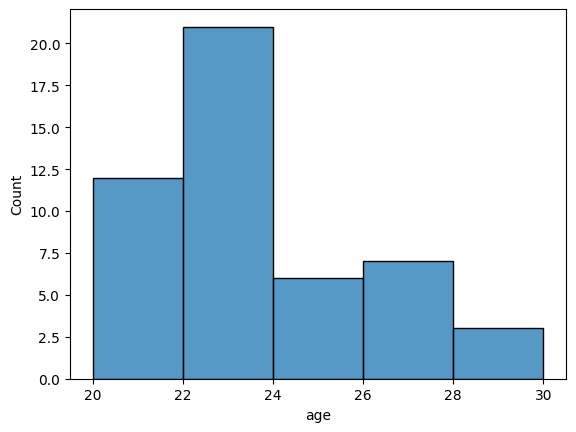

In [242]:
sns.histplot(df['age'], binwidth=2)

<Axes: xlabel='input', ylabel='Count'>

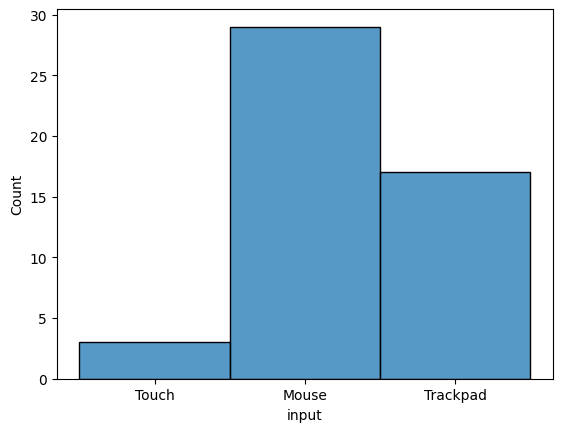

In [243]:
sns.histplot(df['input'])

In [234]:
with open('./opentext.txt', 'w') as f:
    f.write(df[pd.notna(df['opentext'])]['opentext'].str.cat(sep='\n\n===========\n\n'))